In [1]:
from sklearn.model_selection import train_test_split
import pandas
import numpy
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from pprint import pprint

**Reading Data**

In [27]:
data = pandas.read_csv('cs-training.csv')

In [28]:
# data.head()

**Removing NaNs and cleaning data**

In [29]:
data.dropna(axis=0,how='any',subset=['NumberOfDependents'],inplace=True)
data.dropna(axis=0,how='any',subset=['MonthlyIncome'],inplace=True)
data.reset_index()

train_frame = data[data.columns[1:]]
train_frame.columns[1:]

Index(['RevolvingUtilizationOfUnsecuredLines', 'age',
       'NumberOfTime30-59DaysPastDueNotWorse', 'DebtRatio', 'MonthlyIncome',
       'NumberOfOpenCreditLinesAndLoans', 'NumberOfTimes90DaysLate',
       'NumberRealEstateLoansOrLines', 'NumberOfTime60-89DaysPastDueNotWorse',
       'NumberOfDependents'],
      dtype='object')

In [30]:
train_frame.head()

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0
1,0,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0
2,0,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0
3,0,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0
4,0,0.907239,49,1,0.024926,63588.0,7,0,1,0,0.0


**Creating new features and cleaning more**

In [31]:
train_frame['MonthlyDebt'] = train_frame['DebtRatio']*train_frame['MonthlyIncome']
train_frame['NumOfPastDue'] = train_frame['NumberOfTimes90DaysLate']+train_frame['NumberOfTime60-89DaysPastDueNotWorse'] +train_frame['NumberOfTime30-59DaysPastDueNotWorse']
train_frame['MonthlyBalance'] = train_frame['MonthlyIncome']-train_frame['MonthlyDebt']
train_frame['NumOfOpenCreditLines'] = train_frame['NumberOfOpenCreditLinesAndLoans']-train_frame['NumberRealEstateLoansOrLines']
train_frame['IncomePerPerson'] = train_frame['MonthlyIncome']/(train_frame['NumberOfDependents']+1)

# We need only the observations where MonthlyBalance is positive
train_frame['MonthlyBalance'][train_frame['MonthlyBalance'] <= 0] = 1

C:\Applications\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [32]:
train_frame.columns

Index(['SeriousDlqin2yrs', 'RevolvingUtilizationOfUnsecuredLines', 'age',
       'NumberOfTime30-59DaysPastDueNotWorse', 'DebtRatio', 'MonthlyIncome',
       'NumberOfOpenCreditLinesAndLoans', 'NumberOfTimes90DaysLate',
       'NumberRealEstateLoansOrLines', 'NumberOfTime60-89DaysPastDueNotWorse',
       'NumberOfDependents', 'MonthlyDebt', 'NumOfPastDue', 'MonthlyBalance',
       'NumOfOpenCreditLines', 'IncomePerPerson'],
      dtype='object')

**Analysis of each Column**

In [33]:
train_frame['age'].describe()

count    120269.000000
mean         51.289792
std          14.426684
min           0.000000
25%          40.000000
50%          51.000000
75%          61.000000
max         103.000000
Name: age, dtype: float64

**Plot the distribution of each variable to see how skewed they are**

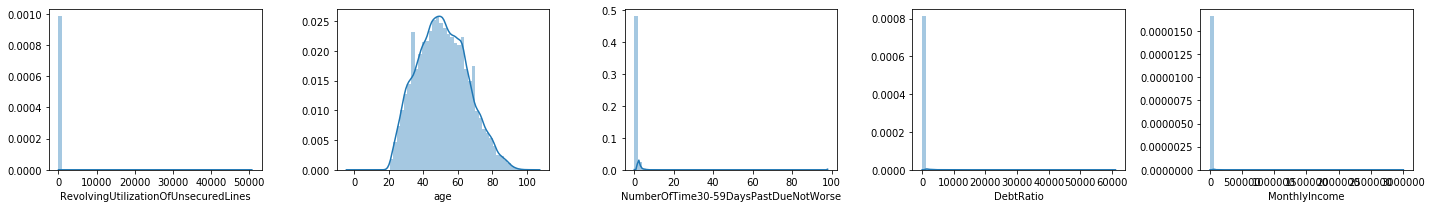

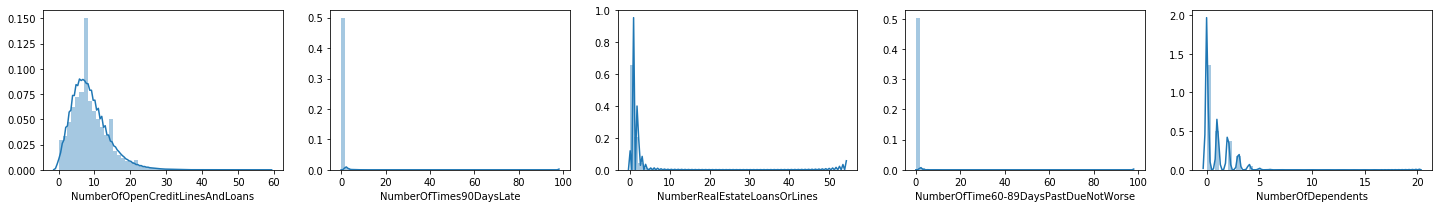

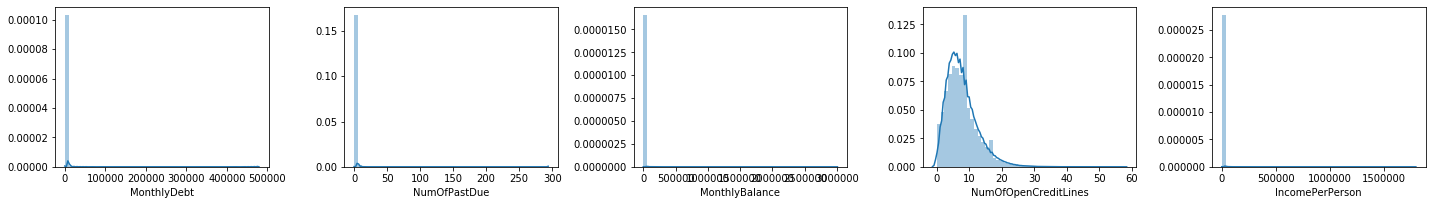

In [34]:
# Uncomment below lines if needed
columns = train_frame.columns[1:]
for cols in numpy.split(columns, 3):
    fig, axes = plt.subplots(1, len(cols), figsize = (20, 3))
    for each in range(len(cols)):
        sns.distplot(train_frame[cols[each]], ax=axes[each])
    plt.tight_layout()

**Taking log transform to reduce skeweness in some variables**

In [35]:
for column in ['RevolvingUtilizationOfUnsecuredLines', 'NumberOfTime30-59DaysPastDueNotWorse', 'NumberOfTimes90DaysLate', 'NumberOfTime60-89DaysPastDueNotWorse', 'NumOfPastDue', 'MonthlyDebt',
              'MonthlyIncome', 'DebtRatio', 'NumberRealEstateLoansOrLines', 'IncomePerPerson', 'MonthlyBalance']:
    train_frame[column] = numpy.log10(1 + train_frame[column].values)

**Plot distribution again**

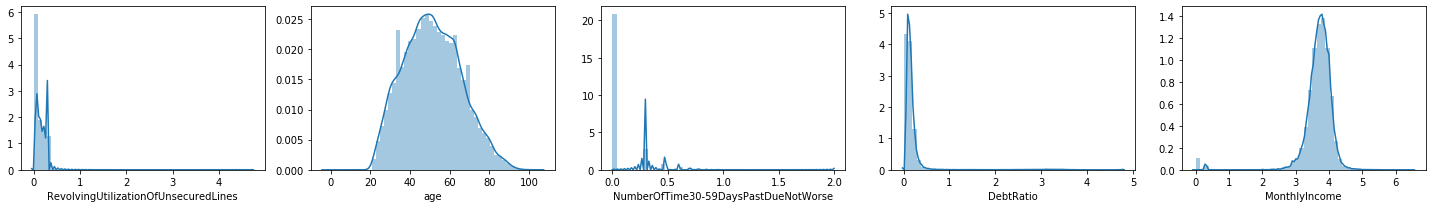

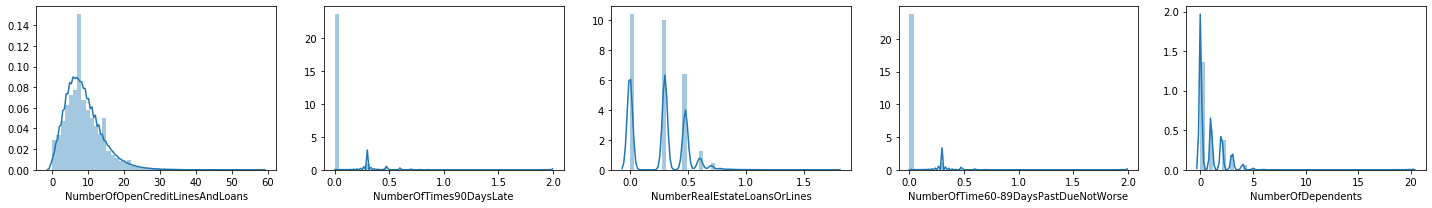

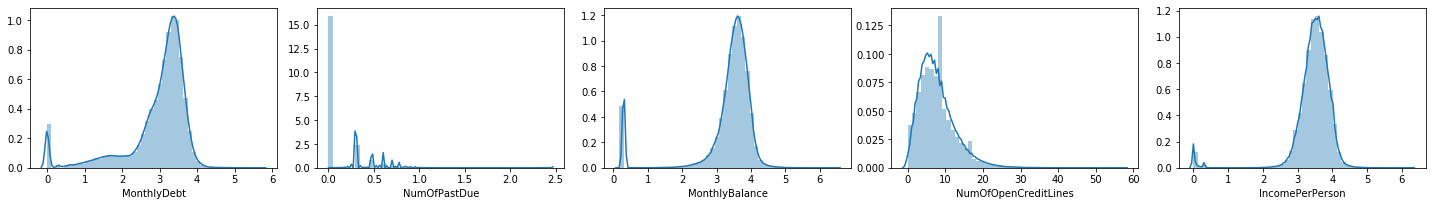

In [36]:
# Uncomment below lines if needed

columns = train_frame.columns[1:]
for cols in numpy.split(columns, 3):
    fig, axes = plt.subplots(1, len(cols), figsize = (20, 3))
    for each in range(len(cols)):
        sns.distplot(train_frame[cols[each]], ax=axes[each])
    plt.tight_layout()

**Removing outliers**

In [37]:
train_frame = train_frame[train_frame['age'] > 0]
train_frame = train_frame[train_frame['age'] < 99]

**Util Methods**

In [38]:
def split_dataset(features):
    x = train_frame[features]
    y = train_frame['SeriousDlqin2yrs']
    return train_test_split(x, y, test_size=0.2, random_state=0)

In [39]:
def scalar_transform(x_train, x_test):
    scaler = StandardScaler()
    scaler.fit(x_train)
    return scaler.transform(x_train), scaler.transform(x_test)

In [40]:
def tune_hyper_parameters(x_train, y_train):
    rf = RandomForestClassifier(oob_score=True, \
                                min_samples_split=2, \
                                min_samples_leaf=50, \
                                n_jobs=-1, \
                                #class_weight="balanced",\
                                class_weight="balanced_subsample", \
                                bootstrap=True\
                                )
    param_grid = {"n_estimators": [90, 100, 110, 130], "max_features": [2, 3, 4], "min_samples_leaf":[50]}
    grid_search = GridSearchCV(rf, cv=10, scoring='roc_auc', param_grid=param_grid, iid=False)
    grid_search.fit(x_train, y_train)
    pprint(grid_search.best_params_)
    pprint(grid_search.best_score_)

In [41]:
def train(x_train, y_train):
    rf = RandomForestClassifier(n_estimators=130, \
                                oob_score=True, \
                                min_samples_split=2, \
                                min_samples_leaf=50, \
                                n_jobs=-1, \
                                #class_weight="balanced",\
                                class_weight="balanced_subsample", \
                                bootstrap=True, \
                                max_features=3, \
                                criterion='entropy'
                                )
    return rf.fit(x_train, y_train)

In [63]:
def plot(y_test, y_pred):
    conf_matrix = metrics.confusion_matrix(y_test, y_pred)
    ax = sns.heatmap(conf_matrix, annot = True, fmt = "d", square=True, cmap = plt.cm.Greens)
    bottom, top = ax.get_ylim()
    ax.set_ylim(bottom + 0.5, top - 0.5) #to fix glitch 
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title('Confusion matrix')
    plt.tight_layout()

**Feature Engineering**

We have used all the variables and plotted their relative importance.

In [64]:
features = train_frame.columns[1:]
x_train, x_test, y_train, y_test = split_dataset(features)
x_train, x_test = scalar_transform(x_train, x_test)

**Hyper-Parameter tuning**

Already done and the output has been used in the method 'train'

In [65]:
# tune_hyper_parameters(x_train, y_train)

In [66]:
rf = train(x_train, y_train)

In [67]:
y_pred = rf.predict(x_test)

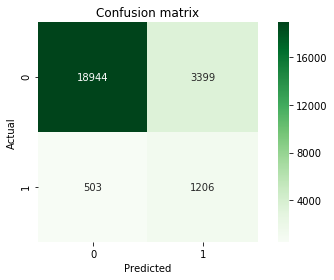

In [68]:
plot(y_test, y_pred)

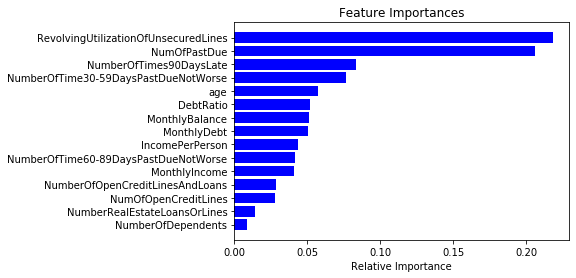

In [69]:
importances = rf.feature_importances_
indices = numpy.argsort(importances)
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

**Training on selected features**

In [70]:
features = ['RevolvingUtilizationOfUnsecuredLines','MonthlyDebt', 'MonthlyIncome', 'DebtRatio', 'age', 'IncomePerPerson', 'MonthlyBalance', 'NumOfOpenCreditLines',
            'NumberOfTime30-59DaysPastDueNotWorse', 'NumberOfTime60-89DaysPastDueNotWorse', 'NumberOfTimes90DaysLate', 'NumOfPastDue']
x_train, x_test, y_train, y_test = split_dataset(features)
x_train, x_test = scalar_transform(x_train, x_test)
rf = train(x_train, y_train)

In [71]:
y_pred = rf.predict(x_test)

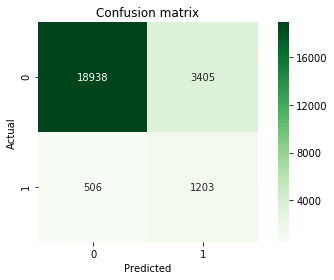

In [72]:
plot(y_test, y_pred)

**Predicting Test data**

In [52]:
test_data = pandas.read_csv('cs-test.csv')

In [53]:
test_data = test_data[data.columns[2:]]

In [54]:
test_data['MonthlyDebt'] = test_data['DebtRatio']*test_data['MonthlyIncome']
test_data['NumOfPastDue'] = test_data['NumberOfTimes90DaysLate']+test_data['NumberOfTime60-89DaysPastDueNotWorse'] +test_data['NumberOfTime30-59DaysPastDueNotWorse']
test_data['NumOfOpenCreditLines'] = test_data['NumberOfOpenCreditLinesAndLoans']-test_data['NumberRealEstateLoansOrLines']
test_data['IncomePerPerson'] = test_data['MonthlyIncome']/(test_data['NumberOfDependents']+1)
test_data['MonthlyBalance'] = test_data['MonthlyIncome']-test_data['MonthlyDebt']

test_data['MonthlyBalance'][test_data['MonthlyBalance'] <= 0] = 1

C:\Applications\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [55]:
for column in ['RevolvingUtilizationOfUnsecuredLines', 'NumberOfTime30-59DaysPastDueNotWorse', 'NumberOfTimes90DaysLate', 'NumberOfTime60-89DaysPastDueNotWorse', 'NumOfPastDue', 'MonthlyDebt',
              'MonthlyIncome', 'DebtRatio', 'NumberRealEstateLoansOrLines', 'IncomePerPerson', 'MonthlyBalance']:
    test_data[column] = numpy.log10(1 + test_data[column].values)

In [56]:
x = test_data[features]

In [57]:
scaler = StandardScaler()
x = scaler.fit_transform(x)

In [58]:
imp = SimpleImputer()
imp = imp.fit(x)
x = imp.transform(x)

In [59]:
probs = rf.predict_proba(x)
dlq = rf.predict(x)

In [60]:
probs = [each[1] for each in probs]

In [61]:
out = pandas.DataFrame()
out['Probability'] = probs
out['SeriousDlqin2yrs'] = dlq
out.index = out.index+1

In [62]:
out.to_csv('out.csv')